# Notebook 12: Discourse Analysis - Sentiment

**Project: Data Triage of Transcribed Nixon Tapes** <br>
*Michelle Ballard and April Crompton* <br>
Loyola University Maryland Data Science Project 

## Import Statements

In [42]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import PercentFormatter
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from textblob import TextBlob # for sentiment analysis
from wordcloud import WordCloud

In [43]:
# unpickle preserved dataframes 
# From 03: Cleaned/combined with abstract

pkl_file = open('cleaned_combined.pkl', 'rb')

df_all_combined = pickle.load(pkl_file)

df_speakers_combined = pickle.load(pkl_file)
print("\n~~~df_speakers_combined~~~\n")
print(df_speakers_combined.info())

df_chunks_combined = pickle.load(pkl_file)
print("\n~~~df_chunks_combined~~~\n")
print(df_chunks_combined.info())

# from 07: Preprocessing_speakers
pkl_file = open('pipelines_cln.pkl', 'rb')

df_all_pipe = pickle.load(pkl_file)

df_speakers_pipe = pickle.load(pkl_file)
print("\n~~~df_speakers_pipes~~~\n")
print(df_speakers_pipe.info())


~~~df_speakers_combined~~~

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34847 entries, 0 to 34846
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   corpus                 34847 non-null  object         
 1   exhibit                34847 non-null  object         
 2   speaker_clean          34847 non-null  object         
 3   nonspeech_clean        34847 non-null  object         
 4   speech_final           34847 non-null  object         
 5   speech_final_expanded  34847 non-null  object         
 6   location               34847 non-null  object         
 7   date                   34847 non-null  datetime64[ns] 
 8   start_dtime            34847 non-null  datetime64[ns] 
 9   end_dtime              34847 non-null  datetime64[ns] 
 10  time_diff              34847 non-null  timedelta64[ns]
dtypes: datetime64[ns](3), object(7), timedelta64[ns](1)
memory usage: 3.2+ MB
Non

In [3]:
# Read in stopwords created in preprocessing step
pop_stop_words = list(ENGLISH_STOP_WORDS)+["nt", "ve"] #sklearn len 318

## Create speaker word clouds 

In [4]:
# Get a processed word list
df_speakers_collapsed = df_speakers_pipe[['speaker_clean','Pipeline5']].copy()
df_speakers_collapsed = df_speakers_collapsed.groupby(['speaker_clean']).sum()

In [5]:
# Create a string from processed word list for the word cloud
def stringitize(txtlst):
    if isinstance(txtlst, list):
        string = ' '.join(str(e.strip()) for e in txtlst)
    else: string = str(txtlst)
    return string

df_speakers_collapsed['strPipe'] = df_speakers_collapsed['Pipeline5'].apply(lambda x: stringitize(x))

In [6]:
# Drop short speakers
df_speakers_collapsed['strPipelen'] = df_speakers_collapsed['strPipe'].apply(lambda x: len(x))
df_speakers_collapsed = df_speakers_collapsed.drop(
    df_speakers_collapsed[df_speakers_collapsed.strPipelen < 50].index)

In [7]:
# Sort by length of speech
df_speakers_collapsed.sort_values(by='strPipelen', ascending=False, inplace=True)
# Review
display(df_speakers_collapsed.head())
display(df_speakers_collapsed.tail())

Pipeline5  \
speaker_clean                                                      
NIXON          [john, sit, sit, dean, summary, day, full_comm...   
HALDEMAN       [john, does, friday, colson, lawyer, firm, col...   
EHRLICHMAN     [round, round, come, questions, answers, backe...   
DEAN           [good, morning, john, caught, the_way, asked, ...   
COLSON         [probably, typical, little_bit, apology, sessi...   

                                                         strPipe  strPipelen  
speaker_clean                                                                 
NIXON          john sit sit dean summary day full_committee q...      485860  
HALDEMAN       john does friday colson lawyer firm colson tol...      223087  
EHRLICHMAN     round round come questions answers backed star...      162926  
DEAN           good morning john caught the_way asked gray ho...      114408  
COLSON         probably typical little_bit apology session wa...       36295

Pipeline5  \
speaker_clean                                                      
SANCHEZ        [good, morniniz, sir, coke, si, senor, cokes, ...   
WHITAKER       [frank, white, kansas, raise, started, concern...   
WAITER         [care, coffee, sir, certainly, air, sir, presi...   
EHMACOUN       [permitted, good, waffle, afraid, subject, tre...   
HART           [excuse, mr_president, mr_petersen, street, ov...   

                                                         strPipe  strPipelen  
speaker_clean                                                                 
SANCHEZ        good morniniz sir coke si senor cokes sir sir ...          73  
WHITAKER       frank white kansas raise started concern produ...          68  
WAITER         care coffee sir certainly air sir president wa...          58  
EHMACOUN       permitted good waffle afraid subject tremendou...          56  
HART           excuse mr_president mr_petersen street oval of...          50

In [8]:
# Make word clouds
wc = WordCloud(stopwords=pop_stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

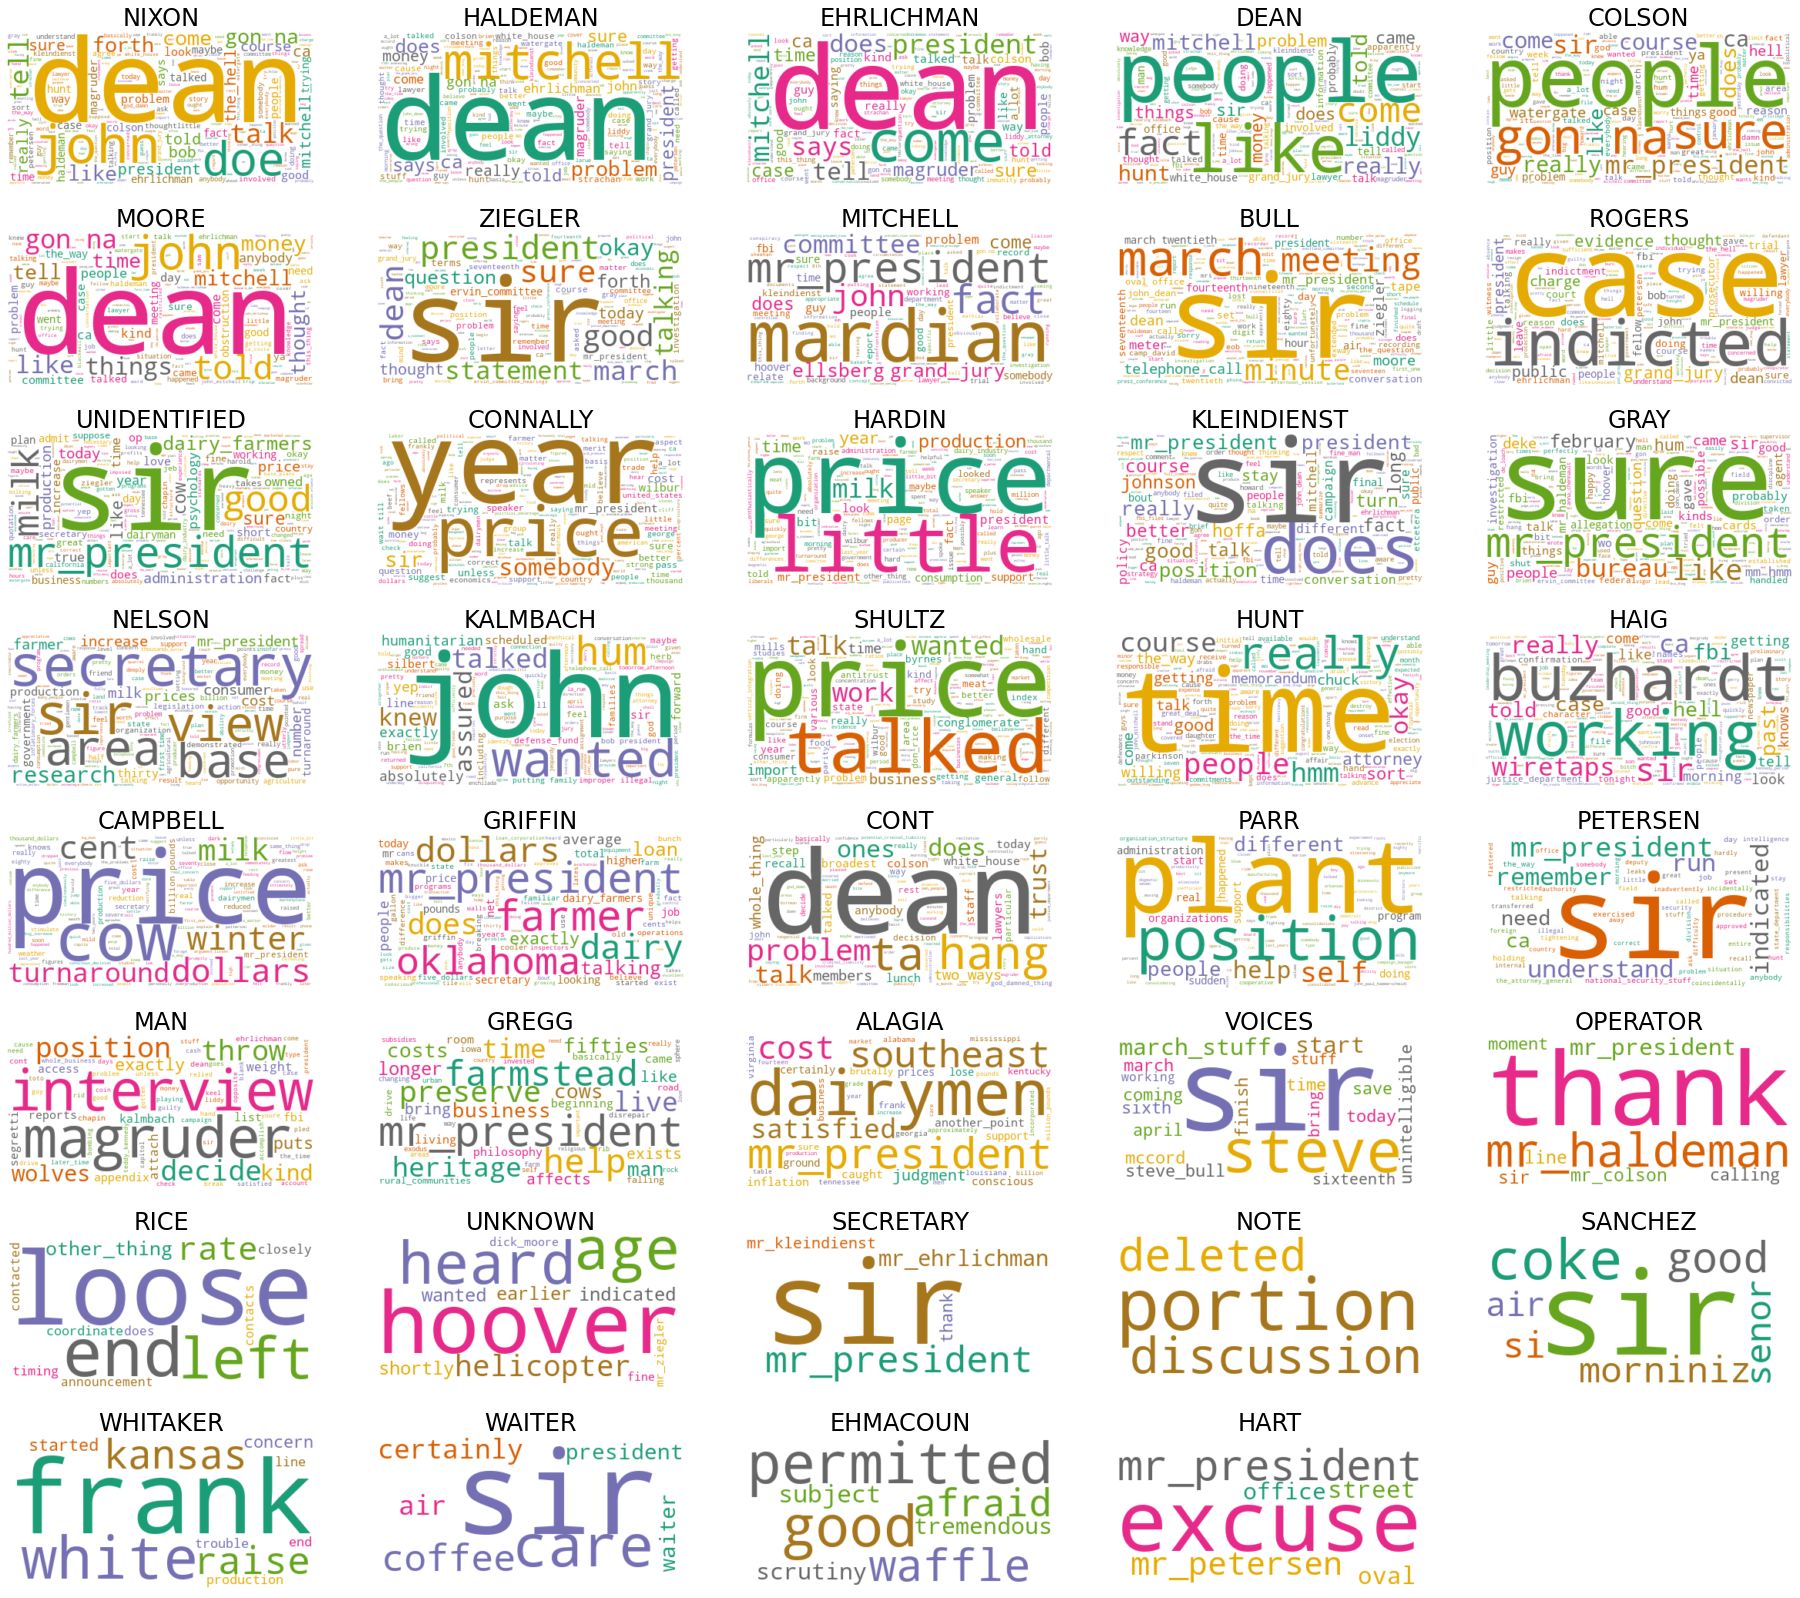

In [9]:
# Reset the output dimensions
plt.rcParams['figure.figsize'] = [32, 40]
# plt.rc('figure', titlesize=100)

# Create subplots for each comedian
for index, speaker in enumerate(df_speakers_collapsed.index):
    wc.generate(df_speakers_collapsed.strPipe.loc[speaker])
    plt.subplot(11, 5, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(speaker, fontdict={'fontsize': 24})
    
plt.show()

# stop words will need to be more aggressive to cleanse noise

## Sentiment Analysis
The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

https://textblob.readthedocs.io/en/dev/quickstart.html

In [10]:
# Create lambda functions to find polarity and subjectivity

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

### Sentiment Per Speaker per statement

In [11]:
# use expanded contractions to capture each word
df_speakers_sentiment = df_speakers_combined[['exhibit','speaker_clean','speech_final_expanded']].copy()
speakers_speech = df_speakers_sentiment['speech_final_expanded'] # must be strings

In [12]:
df_speakers_sentiment['polarity'] = speakers_speech.apply(pol)
df_speakers_sentiment['subjectivity'] = speakers_speech.apply(sub)
display(df_speakers_sentiment)

exhibit speaker_clean  \
0      exhibit_12         NIXON   
1      exhibit_12          DEAN   
2      exhibit_12         NIXON   
3      exhibit_12          DEAN   
4      exhibit_12         NIXON   
...           ...           ...   
34842     039-083      HALDEMAN   
34843     039-083         NIXON   
34844     039-083      HALDEMAN   
34845     039-083         NIXON   
34846     039-083      HALDEMAN   

                                   speech_final_expanded  polarity  \
0                             John, sit down, sit down.  -0.155556   
1                                         Good morning.   0.700000   
2       Well, what is the Dean summary of the day abo...  0.000000   
3       John caught me on the way out and asked me ab...  0.013846   
4                                       Full committee.   0.350000   
...                                                  ...       ...   
34842    sounded pretty good when I wrote them out an...  0.475000   
34843   Fine, well, we just, uh, if we could preempt ...  0.351190   
34844                                              Yep.   0.000000   
34845                                        Okay, boy.   0.500000   
34846                                               Okay  0.500000   

       subjectivity  
0          0.288889  
1          0.600000  
2          0.000000  
3          0.342308  
4          0.550000  
...             ...  
34842      0.800000  
34843      0.517857  
34844      0.000000  
34845      0.500000  
34846      0.500000  

[34847 rows x 5 columns]

#### All Speakers

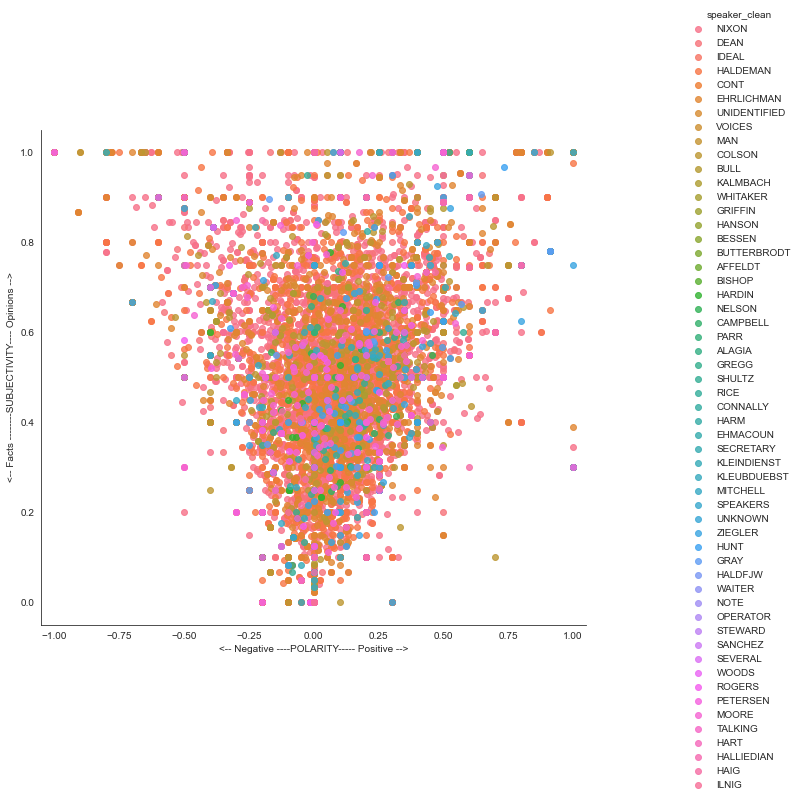

In [13]:
# Set Plotting variables
x = df_speakers_sentiment.polarity
y = df_speakers_sentiment.subjectivity
c = df_speakers_sentiment.speaker_clean
polmin, polmax = df_speakers_sentiment.polarity.min(), df_speakers_sentiment.polarity.max()
if abs(polmin)>abs(polmax):
    xmin, xmax = polmin-.05, abs(polmin)+.05
else:
    xmin, xmax = -polmax-.05, polmax+.05
sns.set_style("white")
sentiment = sns.lmplot(x='polarity', y='subjectivity', data=df_speakers_sentiment,
                       fit_reg=False, hue="speaker_clean")
sentiment.figure.set_size_inches(12,8)
sentiment.set(ylim=(-0.05, 1.05), xlim=(xmin,xmax))
sentiment.set( xlabel = "<-- Negative ----POLARITY----- Positive -->",
              ylabel = "<-- Facts --------SUBJECTIVITY---- Opinions -->");

In [14]:
df_speaker_collapsed = df_speakers_sentiment.groupby('speaker_clean')['polarity', 'subjectivity'].mean()
indexes = df_speaker_collapsed[ (df_speaker_collapsed['polarity'] == 0) & (df_speaker_collapsed['subjectivity'] == 0) ].index
df_speaker_collapsed.drop(indexes,inplace=True)
df_speaker_collapsed = df_speaker_collapsed.reset_index()
df_speaker_collapsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   speaker_clean  39 non-null     object 
 1   polarity       39 non-null     float64
 2   subjectivity   39 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.0+ KB


/var/folders/zy/nhwc10hx7glbkwfvg8qcxldr0000gp/T/ipykernel_785/3663888059.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_speaker_collapsed = df_speakers_sentiment.groupby('speaker_clean')['polarity', 'subjectivity'].mean()


In [15]:
#filtering index where marks =100
 
indexes = df_speaker_collapsed[ (df_speaker_collapsed['polarity'] == 0) & (df_speaker_collapsed['subjectivity'] == 0) ].index

#droping mutiple rows based on column value
df_speaker_collapsed.drop(indexes,inplace=True)
df_speaker_collapsed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   speaker_clean  39 non-null     object 
 1   polarity       39 non-null     float64
 2   subjectivity   39 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB


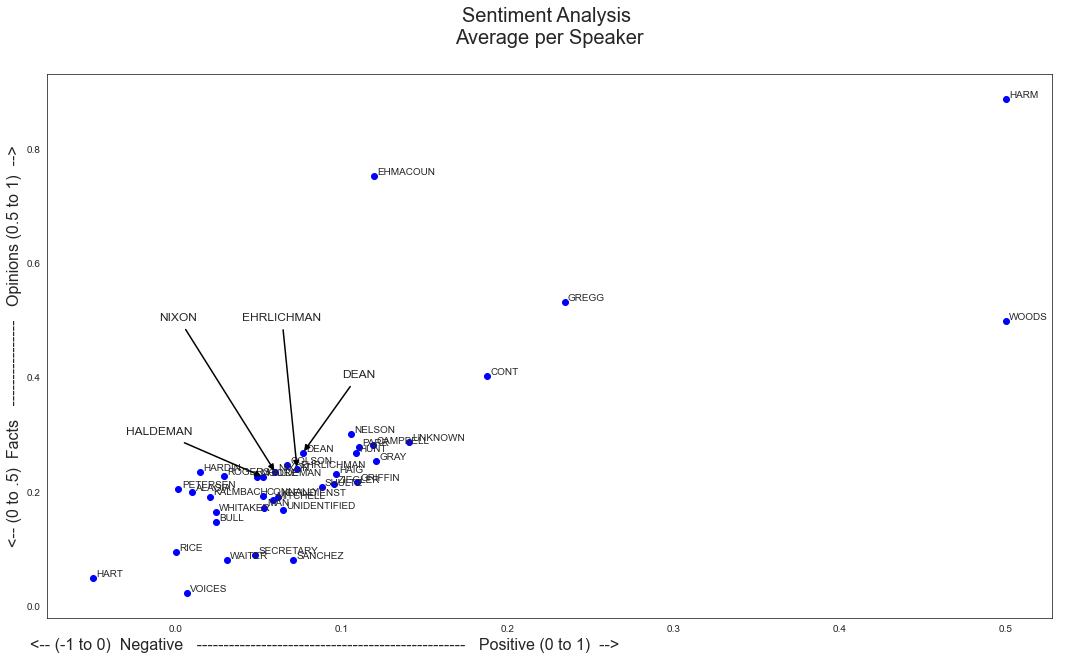

In [16]:
# Plot average speaker sentiment
nixon_loc = df_speaker_collapsed[df_speaker_collapsed.speaker_clean=='NIXON'].index[0]
haldeman_loc = df_speaker_collapsed[df_speaker_collapsed.speaker_clean=='HALDEMAN'].index[0]
dean_loc = df_speaker_collapsed[df_speaker_collapsed.speaker_clean=='DEAN'].index[0]
ehrlichman_loc = df_speaker_collapsed[df_speaker_collapsed.speaker_clean=='EHRLICHMAN'].index[0]

plt.rcParams['figure.figsize'] = [18, 10]

for index, speaker in enumerate(df_speaker_collapsed.index):
    x = df_speaker_collapsed.polarity.loc[speaker]
    y = df_speaker_collapsed.subjectivity.loc[speaker]
    plt.scatter(x, y, color='blue')
    plt.text(x+.002, y+.002, df_speaker_collapsed['speaker_clean'][index], fontsize=10)

plt.annotate('NIXON'.format(2),
             xy=(df_speaker_collapsed.polarity.loc[nixon_loc], df_speaker_collapsed.subjectivity.loc[nixon_loc]),
             xytext=(-0.01, 0.5), size=12,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))

plt.annotate('HALDEMAN'.format(2),
             xy=(df_speaker_collapsed.polarity.loc[haldeman_loc], df_speaker_collapsed.subjectivity.loc[haldeman_loc]),
             xytext=(-0.03, 0.3), size=12,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))
plt.annotate('EHRLICHMAN'.format(2),
             xy=(df_speaker_collapsed.polarity.loc[ehrlichman_loc], df_speaker_collapsed.subjectivity.loc[ehrlichman_loc]),
             xytext=(0.04, 0.5), size=12,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))
plt.annotate('DEAN'.format(2),
             xy=(df_speaker_collapsed.polarity.loc[dean_loc], df_speaker_collapsed.subjectivity.loc[dean_loc]),
             xytext=(0.1, 0.4), size=12,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))
    
plt.title('Sentiment Analysis \nAverage per Speaker', fontsize=20, pad = 30)
plt.xlabel('<-- (-1 to 0)  Negative   '+"-"*50+'   Positive (0 to 1)  -->'+" "*100, fontsize=16)
plt.ylabel('<-- (0 to .5)  Facts   ----------------   Opinions (0.5 to 1)  -->', fontsize=16)

plt.show()

#### Only speakers with the most speech
most speech based on counting the number of times they spoke
ref: https://www.statology.org/pareto-chart-python/

In [17]:
df_pareto = pd.DataFrame(df_speakers_sentiment.speaker_clean.value_counts())
df_pareto['cumperc'] = df_pareto['speaker_clean'].cumsum()/df_pareto['speaker_clean'].sum()*100
df_pareto.head()

speaker_clean    cumperc
NIXON               15777  45.275060
HALDEMAN             6436  63.744368
EHRLICHMAN           5116  78.425689
DEAN                 3172  87.528338
COLSON               1140  90.799782

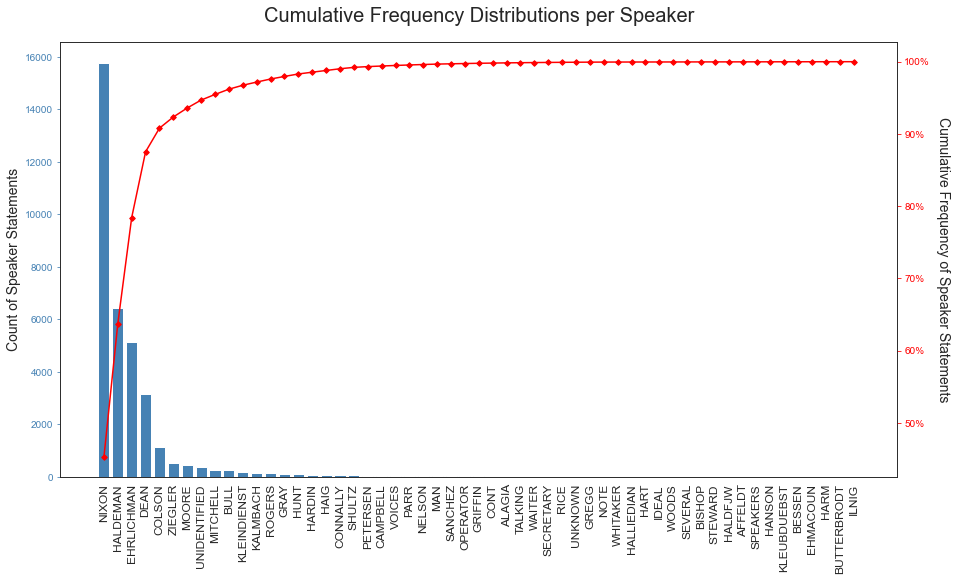

In [18]:
#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(df_pareto.index, df_pareto['speaker_clean'], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['cumperc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='x', rotation=90, labelsize=12)
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)
plt.title("Cumulative Frequency Distributions per Speaker", fontsize = 20, pad = 20)
ax.set_ylabel('Count of Speaker Statements', fontsize=14)
ax2.set_ylabel('Cumulative Frequency of Speaker Statements',rotation = 270, fontsize=14, labelpad=20)

#display Pareto chart
plt.show()

Nixon, Haldeman, Ehrlichman, and Dean had the huge majority of discussions.

In [19]:
# limit to main speakers
main_spk = df_pareto[df_pareto.cumperc < 90].index.tolist()
df_main_speakers = df_speakers_sentiment[df_speakers_sentiment.speaker_clean.isin(main_spk)]

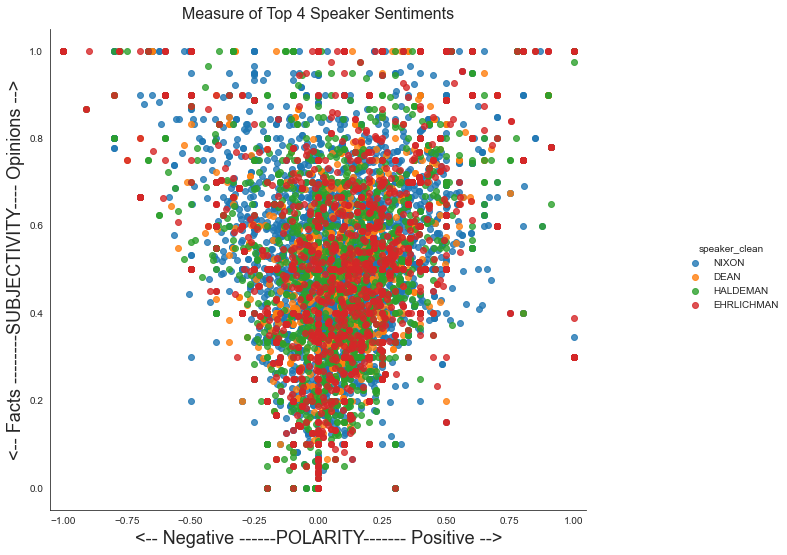

In [20]:
# Set Plotting variables
plt.rcParams['axes.labelsize'] = 18
x = df_main_speakers.polarity
y = df_main_speakers.subjectivity
c = df_main_speakers.speaker_clean
polmin, polmax = df_main_speakers.polarity.min(), df_main_speakers.polarity.max()
if abs(polmin)>abs(polmax):
    xmin, xmax = polmin-.05, abs(polmin)+.05
else:
    xmin, xmax = -polmax-.05, polmax+.05
sns.set_style("white")
sentiment = sns.lmplot(x='polarity', y='subjectivity', data=df_main_speakers,
                       fit_reg=False, hue="speaker_clean")
sentiment.figure.set_size_inches(12,8)
sentiment.set(ylim=(-0.05, 1.05), xlim=(xmin,xmax))
plt.title("Measure of Top 4 Speaker Sentiments", fontsize = 16, pad = 10)
sentiment.set( xlabel = "<-- Negative ------POLARITY------- Positive -->",
              ylabel = "<-- Facts --------SUBJECTIVITY---- Opinions -->");

In [21]:
# limit to Nixon and Ehrlichman
main_spk = ['NIXON', 'EHRLICHMAN']
df_main_speakers = df_speakers_sentiment[df_speakers_sentiment.speaker_clean.isin(main_spk)]

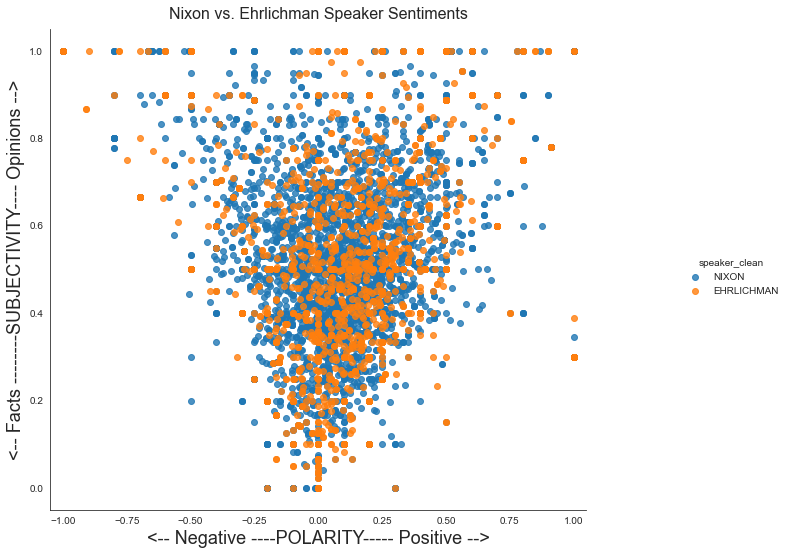

In [22]:
# Set Plotting variables
x = df_main_speakers.polarity
y = df_main_speakers.subjectivity
c = df_main_speakers.speaker_clean
polmin, polmax = df_main_speakers.polarity.min(), df_main_speakers.polarity.max()
if abs(polmin)>abs(polmax):
    xmin, xmax = polmin-.05, abs(polmin)+.05
else:
    xmin, xmax = -polmax-.05, polmax+.05
sns.set_style("white")
sentiment = sns.lmplot(x='polarity', y='subjectivity', data=df_main_speakers,
                       fit_reg=False, hue="speaker_clean")
sentiment.figure.set_size_inches(12,8)
plt.title("Nixon vs. Ehrlichman Speaker Sentiments", fontsize = 16, pad = 10)
sentiment.set(ylim=(-0.05, 1.05), xlim=(xmin,xmax))
sentiment.set( xlabel = "<-- Negative ----POLARITY----- Positive -->",
              ylabel = "<-- Facts --------SUBJECTIVITY---- Opinions -->");

In [23]:
# limit to Nixon and Haldeman
main_spk = ['NIXON', 'HALDEMAN']
df_main_speakers = df_speakers_sentiment[df_speakers_sentiment.speaker_clean.isin(main_spk)]

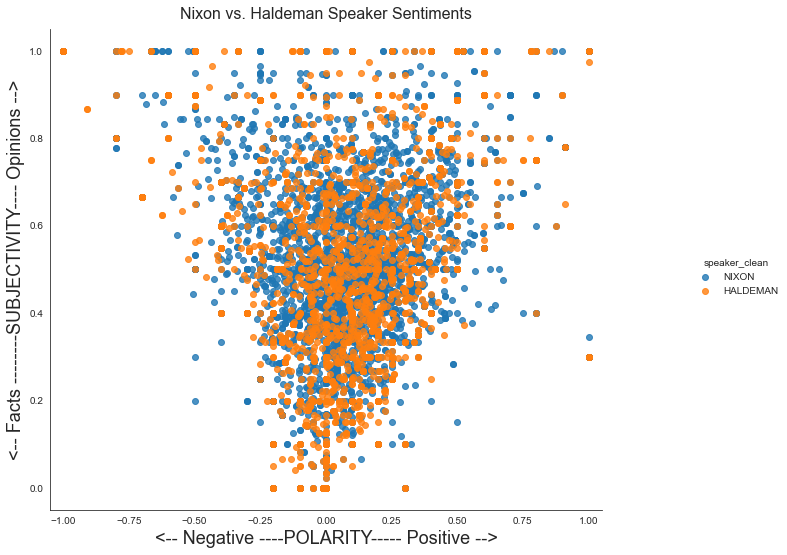

In [24]:
# Set Plotting variables
x = df_main_speakers.polarity
y = df_main_speakers.subjectivity
c = df_main_speakers.speaker_clean
polmin, polmax = df_main_speakers.polarity.min(), df_main_speakers.polarity.max()
if abs(polmin)>abs(polmax):
    xmin, xmax = polmin-.05, abs(polmin)+.05
else:
    xmin, xmax = -polmax-.05, polmax+.05
sns.set_style("white")
sentiment = sns.lmplot(x='polarity', y='subjectivity', data=df_main_speakers,
                       fit_reg=False, hue="speaker_clean")
sentiment.figure.set_size_inches(12,8)
plt.title("Nixon vs. Haldeman Speaker Sentiments", fontsize = 16, pad = 10)
sentiment.set(ylim=(-0.05, 1.05), xlim=(xmin,xmax))
sentiment.set( xlabel = "<-- Negative ----POLARITY----- Positive -->",
              ylabel = "<-- Facts --------SUBJECTIVITY---- Opinions -->");

In [25]:
# limit to Nixon and Dean
main_spk = ['NIXON', 'DEAN']
df_main_speakers = df_speakers_sentiment[df_speakers_sentiment.speaker_clean.isin(main_spk)]

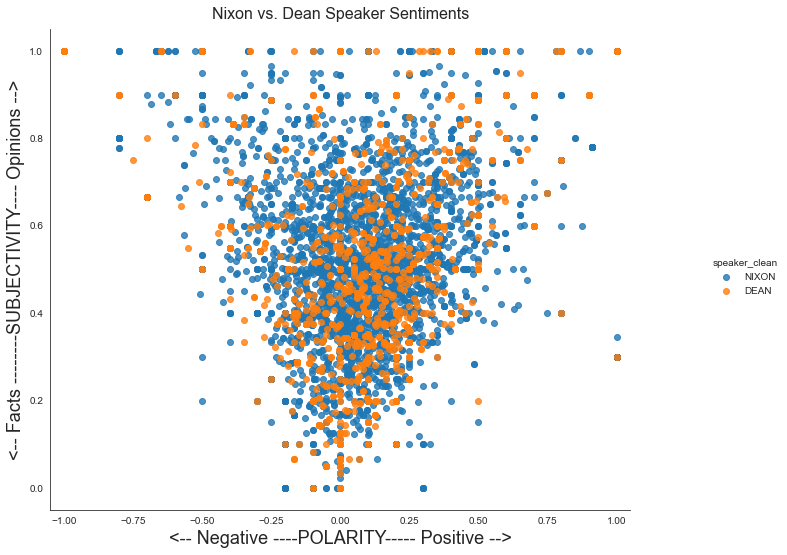

In [26]:
# Set Plotting variables
x = df_main_speakers.polarity
y = df_main_speakers.subjectivity
c = df_main_speakers.speaker_clean
polmin, polmax = df_main_speakers.polarity.min(), df_main_speakers.polarity.max()
if abs(polmin)>abs(polmax):
    xmin, xmax = polmin-.05, abs(polmin)+.05
else:
    xmin, xmax = -polmax-.05, polmax+.05
sns.set_style("white")
sentiment = sns.lmplot(x='polarity', y='subjectivity', data=df_main_speakers,
                       fit_reg=False, hue="speaker_clean")
sentiment.figure.set_size_inches(12,8)
plt.title("Nixon vs. Dean Speaker Sentiments", fontsize = 16, pad = 10)

sentiment.set(ylim=(-0.05, 1.05), xlim=(xmin,xmax))
sentiment.set( xlabel = "<-- Negative ----POLARITY----- Positive -->",
              ylabel = "<-- Facts --------SUBJECTIVITY---- Opinions -->");

### Sentiment Per Exhibit

In [27]:
df_pareto = pd.DataFrame(df_speakers_sentiment.exhibit.value_counts())
df_pareto['cumperc'] = df_pareto['exhibit'].cumsum()/df_pareto['exhibit'].sum()*100
df_pareto.head()

exhibit    cumperc
431-009         1905   5.466755
428-019         1533   9.865986
898-012         1355  13.754412
430-004         1354  17.639969
442-001-069     1314  21.410738

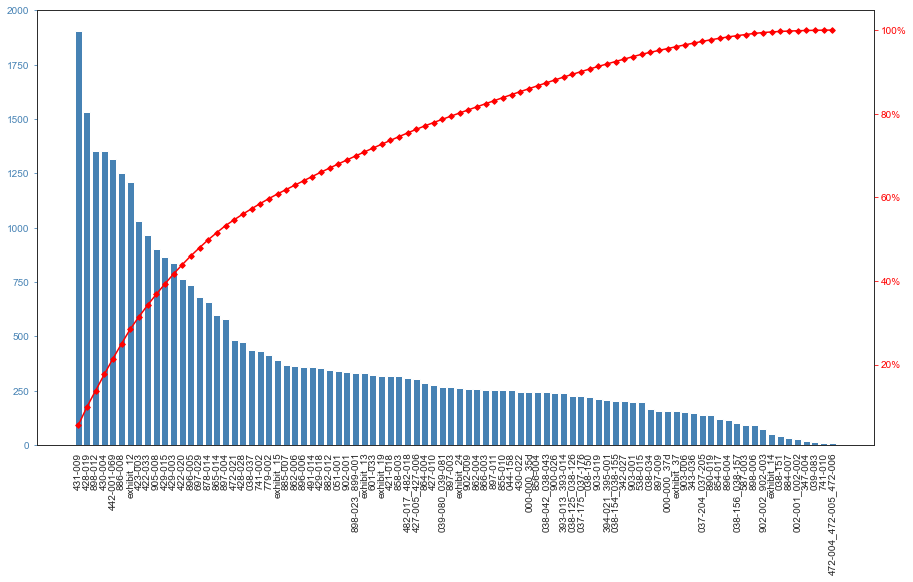

In [28]:
#define aesthetics for plot
color1 = 'steelblue'
color2 = 'red'
line_size = 4

#create basic bar plot
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(df_pareto.index, df_pareto['exhibit'], color=color1)

#add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df_pareto.index, df_pareto['cumperc'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

#specify axis colors
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

#display Pareto chart
plt.show()

#### Original scale

In [44]:
# use expanded contractions to capture each word
df_all_sentiment = df_chunks_combined[['exhibit','orig_exhibit','speech_final_expanded']].copy()
exhibit_speech = df_all_sentiment.set_index('exhibit')
exhibit_speech.head()

orig_exhibit  \
exhibit                          
Part_1_exhibit_12   exhibit_12   
Part_2_exhibit_12   exhibit_12   
Part_3_exhibit_12   exhibit_12   
Part_4_exhibit_12   exhibit_12   
exhibit_13          exhibit_13   

                                               speech_final_expanded  
exhibit                                                               
Part_1_exhibit_12   John, sit down, sit down. Good morning. Well,...  
Part_2_exhibit_12   Sure. Uh, there is no doubt about that.  Mrs....  
Part_3_exhibit_12   Uh, he John does not go until Friday. Friday ...  
Part_4_exhibit_12   But, based on what information it would? For ...  
exhibit_13            Well, you go round and round and you come u...

In [45]:
exhibit_speech['polarity'] = exhibit_speech.speech_final_expanded.apply(pol)
exhibit_speech['subjectivity'] = exhibit_speech.speech_final_expanded.apply(sub)

In [46]:
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_rows', None)
display(exhibit_speech)

orig_exhibit  \
exhibit                               
Part_1_exhibit_12        exhibit_12   
Part_2_exhibit_12        exhibit_12   
Part_3_exhibit_12        exhibit_12   
Part_4_exhibit_12        exhibit_12   
exhibit_13               exhibit_13   
...                             ...   
Part_2_442-001-069      442-001-069   
Part_3_442-001-069      442-001-069   
Part_4_442-001-069      442-001-069   
039-080_039-081     039-080_039-081   
039-083                     039-083   

                                                speech_final_expanded  \
exhibit                                                                 
Part_1_exhibit_12    John, sit down, sit down. Good morning. Well,...   
Part_2_exhibit_12    Sure. Uh, there is no doubt about that.  Mrs....   
Part_3_exhibit_12    Uh, he John does not go until Friday. Friday ...   
Part_4_exhibit_12    But, based on what information it would? For ...   
exhibit_13             Well, you go round and round and you come u...   
...                                                               ...   
Part_2_442-001-069    No, I am not going to bother with them.  I h...   
Part_3_442-001-069   The, uh, FBI clips? I have that morning? They...   
Part_4_442-001-069   Good Which is very good.  And then we take ou...   
039-080_039-081      Yes, please.  Mr. Haldeman, please.  Thank yo...   
039-083              Bob?  Just a moment.  Here you are.  Sorry to...   

                    polarity  subjectivity  
exhibit                                     
Part_1_exhibit_12   0.115325      0.482250  
Part_2_exhibit_12   0.072514      0.525444  
Part_3_exhibit_12   0.109746      0.517320  
Part_4_exhibit_12   0.127106      0.552395  
exhibit_13          0.103199      0.490276  
...                      ...           ...  
Part_2_442-001-069  0.123230      0.492406  
Part_3_442-001-069  0.082210      0.511108  
Part_4_442-001-069  0.222632      0.510656  
039-080_039-081     0.086773      0.546716  
039-083             0.387489      0.592338  

[141 rows x 4 columns]

In [47]:
df_all_sentiment_collapsed = exhibit_speech.reset_index()
df_all_sentiment_collapsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   exhibit                141 non-null    object 
 1   orig_exhibit           141 non-null    object 
 2   speech_final_expanded  141 non-null    object 
 3   polarity               141 non-null    float64
 4   subjectivity           141 non-null    float64
dtypes: float64(2), object(3)
memory usage: 5.6+ KB


### Plot Exhibit Sentiment

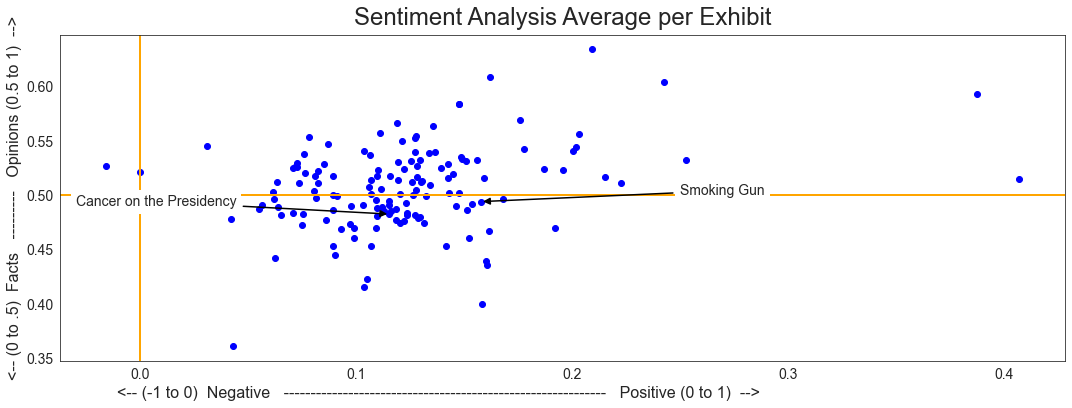

In [52]:
# Include an A-B line for scaling

smokinggun_loc = df_all_sentiment_collapsed[df_all_sentiment_collapsed.orig_exhibit=='741-002'].index[0]
cancerpred_loc = df_all_sentiment_collapsed[df_all_sentiment_collapsed.orig_exhibit=='exhibit_12'].index[0]

# plt.rcParams['figure.figsize'] = [18, 10]
fig, ax = plt.subplots(1,1, figsize = (18,6))

for index, exhibit in enumerate(df_all_sentiment_collapsed.index):
    x = df_all_sentiment_collapsed.polarity.loc[exhibit]
    y = df_all_sentiment_collapsed.subjectivity.loc[exhibit]
    ax.scatter(x, y, color='blue')#, lw=4)

ax.annotate('Smoking Gun'.format(2),
             xy=(df_all_sentiment_collapsed.polarity.loc[smokinggun_loc], df_all_sentiment_collapsed.subjectivity.loc[smokinggun_loc]),
             xytext=(0.25, 0.5), size=14,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))
    

ax.annotate('Cancer on the Presidency'.format(2),
             xy=(df_all_sentiment_collapsed.polarity.loc[cancerpred_loc], df_all_sentiment_collapsed.subjectivity.loc[cancerpred_loc]),
             xytext=(-0.03, 0.49), size=14,
                arrowprops=dict(arrowstyle='-|>', fc="k", ec="k", lw=1.5),
                bbox=dict(pad=5, facecolor="white", edgecolor="none"))
    
ax.set_title('Sentiment Analysis Average per Exhibit', fontsize=24, pad = 10)
ax.set_xlabel('<-- (-1 to 0)  Negative   '+('-'*60)+'   Positive (0 to 1)  -->'+(" "*55), fontsize=16)
ax.set_ylabel('<-- (0 to .5)  Facts   ---------   Opinions (0.5 to 1)  -->', fontsize=16)

# Add an A-B line to emphasize the balance in the chart

# verticle separation
x1 = 0
y1 = .4
x2 = 0
y2 = .6

# horizontal separation
x3 = 0
y3 = .5
x4 = .4
y4 = .5

# add the A-B line
ax.axline((x1, y1), (x2, y2), linewidth=2, color='orange')
ax.axline((x3, y3), (x4, y4), linewidth=2, color='orange');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Re-scaled sentiment to a percentile rank of the score
This ranking is particular to the dataset.

In [49]:
df_all_sentiment_metrics = df_all_sentiment_collapsed.copy()

# interpret Polarity with rank and level
df_all_sentiment_metrics["pol-rank"] = np.argsort(np.argsort(df_all_sentiment_metrics.polarity)) * 100. / (len(df_all_sentiment_metrics.polarity) - 1)
df_all_sentiment_metrics["pol-interp"] = ["positive" if x>0 else "negative" for x in df_all_sentiment_metrics.polarity]

# interpret Subjectivity with rank and level
df_all_sentiment_metrics["subj-rank"] = np.argsort(np.argsort(df_all_sentiment_metrics.subjectivity)) * 100. / (len(df_all_sentiment_metrics.subjectivity) - 1)
df_all_sentiment_metrics["subj-interp"] = ["opinions" if x>0.5 else "facts" for x in df_all_sentiment_metrics.subjectivity]

df_all_sentiment_metrics     

# Percentile rank example, ref Alleo https://stackoverflow.com/questions/12414043/map-each-list-value-to-its-corresponding-percentile

exhibit     orig_exhibit  \
0     Part_1_exhibit_12       exhibit_12   
1     Part_2_exhibit_12       exhibit_12   
2     Part_3_exhibit_12       exhibit_12   
3     Part_4_exhibit_12       exhibit_12   
4            exhibit_13       exhibit_13   
..                  ...              ...   
136  Part_2_442-001-069      442-001-069   
137  Part_3_442-001-069      442-001-069   
138  Part_4_442-001-069      442-001-069   
139     039-080_039-081  039-080_039-081   
140             039-083          039-083   

                                 speech_final_expanded  polarity  \
0     John, sit down, sit down. Good morning. Well,...  0.115325   
1     Sure. Uh, there is no doubt about that.  Mrs....  0.072514   
2     Uh, he John does not go until Friday. Friday ...  0.109746   
3     But, based on what information it would? For ...  0.127106   
4       Well, you go round and round and you come u...  0.103199   
..                                                 ...       ...   
136    No, I am not going to bother with them.  I h...  0.123230   
137   The, uh, FBI clips? I have that morning? They...  0.082210   
138   Good Which is very good.  And then we take ou...  0.222632   
139   Yes, please.  Mr. Haldeman, please.  Thank yo...  0.086773   
140   Bob?  Just a moment.  Here you are.  Sorry to...  0.387489   

     subjectivity   pol-rank pol-interp  subj-rank subj-interp  
0        0.482250  44.285714   positive  23.571429       facts  
1        0.525444  12.142857   positive  71.428571    opinions  
2        0.517320  40.000000   positive  63.571429    opinions  
3        0.552395  60.000000   positive  90.714286    opinions  
4        0.490276  30.714286   positive  33.571429       facts  
..            ...        ...        ...        ...         ...  
136      0.492406  55.000000   positive  36.428571       facts  
137      0.511108  19.285714   positive  52.142857    opinions  
138      0.510656  97.142857   positive  51.428571    opinions  
139      0.546716  22.142857   positive  89.285714    opinions  
140      0.592338  99.285714   positive  97.857143    opinions  

[141 rows x 9 columns]

In [50]:
# Checking
display(df_all_sentiment_metrics[df_all_sentiment_metrics["pol-interp"]=="negative"])
display(df_all_sentiment_metrics[df_all_sentiment_metrics["pol-rank"] == df_all_sentiment_metrics["pol-rank"].max()])

exhibit     orig_exhibit  \
124  038-156_038-157  038-156_038-157   

                                 speech_final_expanded  polarity  \
124     Thank you  Ya  Yes, sir.  Is there any, uh,... -0.015886   

     subjectivity  pol-rank pol-interp  subj-rank subj-interp  
124      0.526879       0.0   negative  72.857143    opinions

exhibit orig_exhibit                              speech_final_expanded  \
26  741-010      741-010     111nere are they? Okay.  I will be up in ju...   

    polarity  subjectivity  pol-rank pol-interp  subj-rank subj-interp  
26  0.407143      0.514286     100.0   positive  57.857143    opinions

## Store polarity metrics

In [51]:
# Pickle Metrics to bring in to Topic Modeling
output = open('sentiment.pkl', 'wb')

pickle.dump(df_all_sentiment_metrics, output)

output.close()